## Import Necessarcy Libraries

In [1]:
import io
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


## Data Preparation

In [2]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
X_train = []
Y_train  = []
X_test = []
Y_test = []
image_size=150

for label in labels:
    trainPath = os.path.join('./Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(label)
    
    testPath = os.path.join('./Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file))
        image = cv2.resize(image, (image_size, image_size))
        X_test.append(image)
        Y_test.append(label)
    
X_train = np.array(X_train)
X_test = np.array(X_test)

100%|█████████████████████████████████████████████████████████████████████████████████| 74/74 [00:00<00:00, 187.34it/s]


## Show sample images from each label

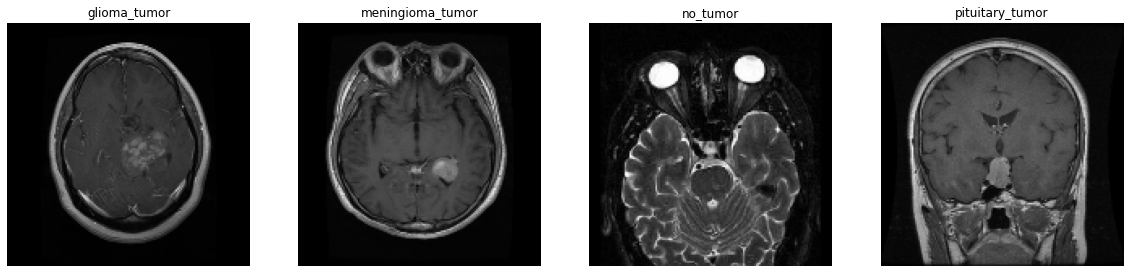

In [5]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
k = 0
for i in range(0,4):
    if i==0: idx=0
    elif i==1: idx=827
    elif i==2: idx=1649
    else: idx=2045
    ax[k].imshow(X_train[idx])
    ax[k].set_title(Y_train[idx])
    ax[k].axis('off')
    k+=1

## Shuffle the train set

In [3]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=28)

In [102]:
X_train.shape

(2870, 150, 150, 3)

## One-Hot encoding

In [4]:
y_train_ = []
for i in Y_train:
    y_train_.append(labels.index(i))
Y_train = y_train_

Y_train = tf.keras.utils.to_categorical(Y_train)

y_test_ = []
for i in Y_test:
    y_test_.append(labels.index(i))
Y_test = y_test_

Y_test = tf.keras.utils.to_categorical(Y_test)

## Split the data into training and validation subsets

In [156]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=28)

## Transfer Learning with EfficientNetB2

In [157]:
base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

In [158]:
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs = base_model.input, outputs=model)

In [159]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 150, 150, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 150, 150, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [168]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Define Callbacks

In [169]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_denta=0.0001, mode='auto', verbose=1)
# tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("brain_tumor_classification.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)
monitor = EarlyStopping(monitor='val_loss',min_delta=1e-3, patience=5, verbose=1, mode='auto', restore_best_weights=True)

## Data Augmentation

In [170]:
datagen = ImageDataGenerator(
featurewise_center=False,
samplewise_center=False,
rotation_range=None,
zoom_range=0.2,
width_shift_range=0.2,
horizontal_flip=False,
vertical_flip=False)

datagen.fit(X_train)

## Train Model

In [171]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
                              validation_data=(X_val, Y_val), 
                              epochs=50, 
                              verbose=1,
                            callbacks=[monitor, checkpoint, reduce_lr])

C:\Users\Cobra\anaconda3\envs\yolov3-tf2-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
72/72 [==============================] - 23s 201ms/step - loss: 0.4341 - accuracy: 0.8587 - val_loss: 0.4446 - val_accuracy: 0.8937

Epoch 00001: val_accuracy improved from -inf to 0.89373, saving model to brain_tumor_classification.h5
Epoch 2/50
72/72 [==============================] - 13s 186ms/step - loss: 0.2255 - accuracy: 0.9219 - val_loss: 0.8497 - val_accuracy: 0.8206

Epoch 00002: val_accuracy did not improve from 0.89373
Epoch 3/50
72/72 [==============================] - 13s 183ms/step - loss: 0.1660 - accuracy: 0.9366 - val_loss: 0.2677 - val_accuracy: 0.9495

Epoch 00003: val_accuracy improved from 0.89373 to 0.94948, saving model to brain_tumor_classification.h5
Epoch 4/50
72/72 [==============================] - 16s 220ms/step - loss: 0.1450 - accuracy: 0.9549 - val_loss: 0.3538 - val_accuracy: 0.9460

Epoch 00004: val_accuracy did not improve from 0.94948
Epoch 5/50
72/72 [==============================] - 14s 195ms/step - loss: 0.1015 - accuracy: 0.9698 - va

## Visusalize model performance

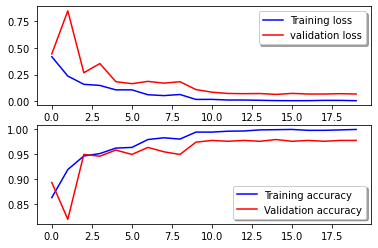

In [172]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

## Evaluate the model

In [173]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(Y_test,axis=1)

In [174]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print("Accuracy on testing dataset: {:.2f}%".format(accuracy*100))

Accuracy on testing dataset: 80.46%
